#  Chatea con datos públicos usando Streamlit e Inteligencia Artificial

## 0. Planteamiento del problema y configuración del entorno

El análisis y consulta de datos de manera interactiva juega un papel fundamental en la exploración y comprensión de información. En este ejercicio práctico, desarrollaremos una aplicación web usando Streamlit que permite cargar datasets del  catálogo del portal de datos abiertos [datos.gob.es](https://datos.gob.es/es/catalogo) y realizar consultas en lenguaje natural aprovechando las capacidades de los modelos de lenguaje (LLM).

Tradicionalmente, el análisis de datos requiere conocimientos de programación y consultas estructuradas. Esta aplicación busca facilitar el acceso a los datos mediante preguntas en lenguaje natural. El sistema utiliza  un modelo de lenguaje para traducir las preguntas del usuario en código Python ejecutable que realiza los análisis solicitados. A través de la interfaz web de Streamlit, se presentan los resultados de manera visual e interactiva.

El desarrollo combina varias tecnologías clave:

- **Streamlit** como framework para crear la interfaz web.
- **Gemini API** de Google para procesar lenguaje natural y generar código.
- **Pandas** para el análisis de datos.
- **Matplotlib** para visualizaciones.

### Librerías requeridas
* [Pandas](https://pandas.pydata.org/): ofrece estructuras de datos flexibles y expresivas diseñadas para facilitar el trabajo con datos estructurados (tabulares, multidimensionales, potencialmente heterogéneos) y series temporales.
* [Matplotlib](https://matplotlib.org/): permite la generación de una gran variedad de gráficos, desde simples diagramas de líneas y dispersión hasta visualizaciones más complejas en 2D y 3D.
* [Tabulate](https://pypi.org/project/tabulate/): facilita la presentación de datos en tablas de formato legible, con soporte para diversos estilos y opciones de personalización.
* [Google Generative AI](https://github.com/google-gemini/generative-ai-python): librería oficial de Python para acceder a los modelos de lenguaje de Google, como Gemini. Proporciona una interfaz simple para generar texto, código y otros tipos de contenido a partir de prompts en lenguaje natural.
* [Requests](https://requests.readthedocs.io/en/latest/): ofrece una interfaz simple y amigable para realizar solicitudes HTTP, permitiendo la interacción con APIs y servicios web de manera sencilla y eficiente, con soporte para peticiones GET, POST, autenticación y manejo de errores.
* [Streamlit](https://streamlit.io/): framework de código abierto que permite crear aplicaciones web interactivas para ciencia de datos y machine learning de manera rápida y sencilla. Convierte scripts de Python en aplicaciones web con una interfaz de usuario atractiva y responsive.
* [Pyngrok](https://pypi.org/project/pyngrok/0.3.2/): herramienta que crea túneles seguros a servicios web locales. Actúa como un proxy inverso que crea un endpoint público seguro (una URL pública) y lo conecta con un puerto en nuestra máquina local.


Para la instalación de librerías, utilizaremos la misma lógica de instalación  de entorno que en el [Ejercicio práctico de tratamiento de etiquetas con Word Embeddings](https://github.com/Admindatosgobes/Laboratorio-de-Datos/tree/main/Visualizaciones/Word%20embeddings%20-%20ejercicio%20pr%C3%A1ctico%20con%20etiquetas%20de%20datos.gob). Para mejorar la legibilidad, realizaremos la carga en cada uno de los módulos de la aplicación.

In [ ]:
# Se cargan librerías de base de Python para gestionar la instalación y carga dinámica de librerías
import importlib
import subprocess
import sys
import time
import traceback
import re
from io import StringIO


def instalar_paquetes():
    """
    Instala los paquetes necesarios si no están presentes en el sistema.
    No carga los módulos, solo asegura que estén instalados.
    """
    paquetes_requeridos = {
        'streamlit': 'streamlit',
        'google-generativeai': 'google-generativeai',
        'pandas': 'pandas',
        'matplotlib': 'matplotlib',
        'requests': 'requests',
        'SpeechRecognition': 'speech_recognition',
        'tabulate': 'tabulate',
        'pyngrok': 'pyngrok'
    }

    print(f"Python: versión {sys.version.split()[0]}")

    for nombre_instalacion, nombre_paquete in paquetes_requeridos.items():
        try:
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "--quiet", nombre_instalacion]
            )
            print(f"✓ {nombre_paquete} instalado/verificado correctamente")
        except subprocess.CalledProcessError:
            print(f"✗ Error al instalar {nombre_paquete}")

instalar_paquetes()

Python: versión 3.11.11
✓ streamlit instalado/verificado correctamente
✓ google-generativeai instalado/verificado correctamente
✓ pandas instalado/verificado correctamente
✓ matplotlib instalado/verificado correctamente
✓ requests instalado/verificado correctamente
✓ speech_recognition instalado/verificado correctamente
✓ tabulate instalado/verificado correctamente
✓ pyngrok instalado/verificado correctamente


## 1. Framework y Gemini API: El motor de procesamiento de lenguaje natural para la aplicación


En esta sección se explica el funcionamiento lógico y estructurado que constituye el núcleo de la aplicación. Se comienza con la generación del contexto del dataset público elegido por el usuario, seguido por la combinación de este contexto con la pregunta del usuario. Este prompt combinado se envía al modelo, que genera código Python como respuesta. Finalmente, este código se ejecuta de manera segura y controlada, produciendo los resultados del análisis solicitado. Esta arquitectura modular no solo facilita el mantenimiento y la depuración del código, sino que también permite la adaptación a diferentes modelos de lenguaje, tipos de datos y usos con cambios mínimos en la implementación.

Este funcionamiento se ilustra en la siguiente imagen:

NOTA: Se ha decidido utilizar Gemini ya que permite, en su nivel gratuito, realizar hasta 15 solicitudes por minuto, generar 1 millón de tokens o términos por minuto y realizar 1.500 solicitudes por día, condiciones que garantizan el uso intensivo de una aplicación conceptual como la desarrollada. Para obtener una clave de API (API Key) basta con registrarse gratuitamente en  [el siguiente enlace](https://ai.google.dev/pricing?hl=es-419#1_5flash). Lo único necesario es tener una cuenta de Google.

![Figura 1. Fuente: elaboración propia][fig1]

[fig1]: 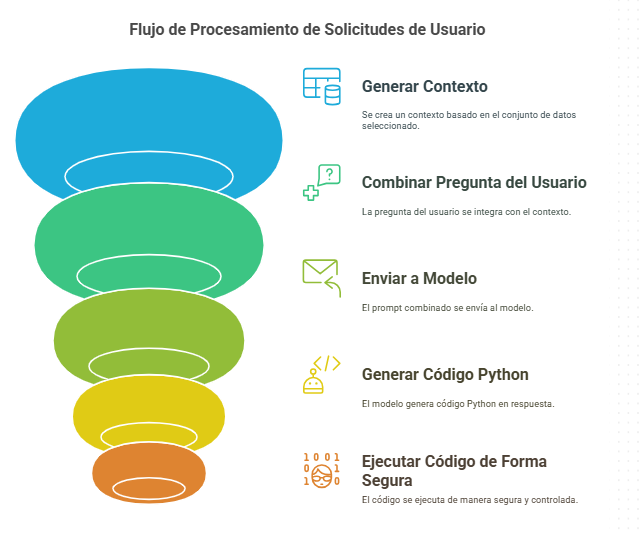

*Figura 1. Fuente: elaboración propia*

La implementación de esta lógica se realiza a través de cuatro funciones principales que se incluyen en el archivo "funciones.py" del repositorio (el comando %%writefile permite ir construyendo desde este notebook el archivo, que servirá como un requerimiento importado al ejecutar "app.py", archivo que a su vez ejecuta la aplicación):


In [ ]:
%%writefile funciones.py
# Imports necesarios para las funciones
import json
import os
import time
import traceback
import re
from pathlib import Path
from io import StringIO, BytesIO
import contextlib
import matplotlib.pyplot as plt
import streamlit as st
import pandas as pd
import requests
import google.generativeai as genai
import urllib.request

Writing funciones.py


### 1.1 Generación del contexto

La función **file_context** es el punto de partida de esta interacción. Esta función toma como entrada un DataFrame de pandas y genera una descripción detallada del mismo que servirá como contexto para el modelo. Su tarea principal es analizar las características del DataFrame, incluyendo sus dimensiones, tipos de datos, estadísticas descriptivas y patrones de valores nulos. Además, genera una plantilla estructurado que incluye guías específicas para la generación de código, asegurando que el modelo comprenda completamente la estructura y particularidades de los datos con los que debe trabajar.

In [ ]:
%%writefile -a funciones.py
def file_context(data):
    """
    Genera un prompt optimizado para el modelo a partir de un DataFrame,
    incluyendo información estructural y guías de código específicas.

    Args:
        data (pd.DataFrame): DataFrame a analizar

    Returns:
        str: Prompt estructurado para el modelo
    """
    rows, cols = data.shape
    numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = data.select_dtypes(include=['object']).columns

    column_info = []
    for i, col in enumerate(data.columns):
        dtype = data[col].dtype
        n_null = data[col].isna().sum()
        n_valid = data[col].count()
        column_info.append(f"#{i}: {col:<20} | {n_valid} válidos, {n_null} nulos | Tipo: {dtype}")

    template = f"""
    ATENCIÓN: El DataFrame ya está cargado en la variable 'data'. NO CREES UN NUEVO DATAFRAME.

    Rol: Actúa como un experto en análisis de datos y programación Python.

    Reglas OBLIGATORIAS:
    1. NO CREAR NUEVOS DATAFRAMES - Usar el DataFrame 'data' existente
    2. NO DEFINIR DATOS DE EJEMPLO - Los datos ya están cargados
    3. NO USAR pd.DataFrame() - El DataFrame ya existe como 'data'
    4. COMENZAR DIRECTAMENTE con el análisis/visualización solicitado

    DataFrame 'data' disponible:
    - Dimensiones: {rows} filas × {cols} columnas
    - Columnas numéricas: {len(numeric_cols)}
    - Columnas categóricas: {len(cat_cols)}
    - Total valores nulos: {data.isnull().sum().sum()}

    Estructura de Columnas en 'data':
    {chr(10).join(column_info)}

    Muestra de 'data':
    {data.head(15).to_string()}

    Estadísticas de 'data':
    {data.describe().to_string()}

    Requisitos Técnicos:
    1. Visualizaciones:
       - Usar SIEMPRE st.pyplot() en lugar de plt.show()
       - Cerrar figuras con plt.close()

    2. Operaciones:
       - Trabajar directamente sobre 'data'
       - Usar .loc/.iloc para indexación
       - Aplicar operaciones vectorizadas
       - Manejar nulos con .fillna() o .dropna()

    3. Agregaciones:
       - Usar .agg() para múltiples operaciones
       - Resetear índices después de groupby

    4. Fechas (si aplica):
       - Convertir a datetime si es necesario
       - Usar .dt para componentes temporales

    Genera el código Python para la siguiente tarea:
    """
    return template.strip()

Appending to funciones.py


### 1.2 Combinación del contexto y la consulta del usuario

La segunda función clave es **context_question**, que actúa como un puente entre el contexto de los datos y la intención del usuario. Esta función toma dos elementos: el contexto generado por file_context y la pregunta del usuario en lenguaje natural. Su trabajo es combinar ambos elementos de manera coherente y estructurada, creando un prompt que maximice la capacidad del modelo para generar código relevante y preciso. La correcta estructuración de este prompt es crucial para obtener respuestas útiles del modelo.

In [ ]:
%%writefile -a funciones.py
def context_question(context,question):
    """Toma la pregunta del usuario y la une al contexto del dataframe"""
    context_question = f"{context}\n{question}"
    return context_question

Appending to funciones.py


### 1.3 Generación de respuesta

La función **generate_response** es la encargada de la comunicación directa con la API de Gemini. Esta función maneja todos los aspectos técnicos de la interacción con el modelo, incluyendo la configuración de la conexión, el envío del prompt y el procesamiento de la respuesta. Actúa como una capa de abstracción que simplifica la complejidad de la comunicación con la API y maneja posibles errores o interrupciones en la comunicación. La función toma como parámetros la clave de API necesaria para la autenticación y el prompt completo generado por la función context_question.

In [ ]:
%%writefile -a funciones.py
from constantes import api_key  # Archivo con la clave API
def generate_response(prompt):
    """
    Genera una respuesta usando el modelo Gemini

    Args:
        prompt (str): Texto de entrada para el modelo

    Returns:
        str: Respuesta generada por el modelo
    """
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel("gemini-1.5-flash")
    try:
        response = model.generate_content(prompt)
        return response.text
    except Exception as e:
        return f"Error al generar respuesta: {str(e)}"

Appending to funciones.py


### 1.4 Ejecución del código generado en la respuesta

Finalmente, la función **execute_generated_code** es la más compleja y crítica del sistema. Su responsabilidad es ejecutar de manera segura el código Python generado por el modelo en el paso anterior. Esta función implementa múltiples capas de seguridad y manejo de errores para garantizar una ejecución robusta. Incluye un sistema de reintentos que, en caso de error, puede solicitar al modelo una versión corregida del código. También se encarga de adaptar el código generado para su uso en Streamlit, capturando apropiadamente las salidas y gestionando la visualización de gráficos.

In [ ]:
%%writefile -a funciones.py
def execute_generated_code(generated_text, model, context, data=None, max_retries=3):
    """
    Ejecuta el código Python generado por Gemini y reintenta con correcciones si hay errores.
    Incluye manejo especial para gráficos de matplotlib.
    """
    attempt = 1

    while attempt <= max_retries:
        # Extraer el código Python del texto generado
        code_blocks = re.findall(r'```python(.*?)```', generated_text, re.DOTALL)

        if not code_blocks:
            return {
                'success': False,
                'error': 'No se encontró código Python en la respuesta generada por el modelo',
                'output': None,
                'code': None,
                'attempts': attempt
            }

        # Tomar el primer bloque de código encontrado
        code = code_blocks[0].strip()

        # Modificar el código para usar st.pyplot() en lugar de plt.show()
        code = code.replace('plt.show()', 'st.pyplot(plt.gcf())')

        output_buffer = StringIO()

        try:
            # Inicializar el diccionario local_vars con el DataFrame y módulos necesarios
            local_vars = {
                'data': data,
                'st': st,  # Añadir Streamlit al contexto local
                'plt': plt  # Añadir matplotlib.pyplot al contexto local
            } if data is not None else {}

            # Asegurar que tenemos las importaciones necesarias en el código
            if 'import matplotlib.pyplot as plt' not in code:
                code = 'import matplotlib.pyplot as plt\n' + code

            # Limpiar cualquier figura existente de matplotlib
            plt.clf()

            # Intentar ejecutar el código
            with contextlib.redirect_stdout(output_buffer):
                with contextlib.redirect_stderr(output_buffer):
                    exec(code, globals(), local_vars)

            # Cerrar la figura actual para liberar memoria
            plt.close()

            return {
                'success': True,
                'error': None,
                'output': output_buffer.getvalue(),
                'code': code,
                'attempts': attempt,
                'local_vars': local_vars
            }

        except Exception as e:
            error_msg = f"Error al ejecutar el código:\n{str(e)}\n"
            error_msg += traceback.format_exc()

            if attempt == max_retries:
                # Si es el último intento, retornar el error
                return {
                    'success': False,
                    'error': error_msg,
                    'output': output_buffer.getvalue(),
                    'code': code,
                    'attempts': attempt
                }

            # Preparar el prompt para la corrección
            error_context = f"""
            {context}

            El código anterior generó el siguiente error:
            {error_msg}

            Este fue el código que falló:
            ```python
            {code}
            ```

            Por favor, genera una versión corregida del código que resuelva el error.
            Solo necesito el código corregido dentro de un bloque de código markdown (```python ... ```),
            sin explicaciones adicionales.
            """

            # Obtener una nueva versión corregida del código
            response = model.generate_content(error_context)
            generated_text = response.text
            attempt += 1

        finally:
            output_buffer.close()

Appending to funciones.py


## 2. Obtención de datos del catálogo datos.gob.es

El portal datos.gob.es ofrece un amplio catálogo de datasets públicos a través de su API. Para nuestra aplicación, nos centramos específicamente en la obtención de datasets en formato Excel, que son más adecuados para el análisis interactivo.

Para optimizar el rendimiento los metadatos descargados se guardan en archivo JSON, evitando la descarga continua.

NOTA: El siguiente bloque de código no es necesariamente ejecutable, puesto que posteriormente se importa una muestra de datasets directamente del repositorio que sobreescribe los datasets que se generan en este bloque. Cada usuario o usuaria es libre de cargar los datasets que desee, pudiendo modificar incluso la función para adaptarlo a un corpus propio de datasets.

In [ ]:
import json
import os
import requests

def get_datasets(limit=None):
    """
    Obtiene datasets de datos.gob.es y devuelve una lista de diccionarios
    con el título, descripción y URL de cada dataset, filtrando solo URLs de Excel.
    """
    datasets = []
    page_number = 0

    # Headers necesarios para que el servidor acepte nuestras peticiones
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept': 'application/json',
        'Accept-Language': 'es'
    }

    while True:
        # Control del límite de datasets a obtener
        if limit is not None and len(datasets) >= limit:
            datasets = datasets[:limit]
            break

        # Configuración de la petición a la API
        url = "https://datos.gob.es/apidata/catalog/dataset"
        params = {
            "_sort": "title",
            "_pageSize": 1000,
            "_page": page_number
        }

        try:
            response = requests.get(url, params=params, headers=headers, timeout=30)
            if response.status_code != 200:
                break

            data = response.json()
            items = data.get('result', {}).get('items', []) if isinstance(data, dict) else data

            if not items:
                break

            # Procesamiento de cada dataset
            for dataset in items:
                # Extracción del título en español
                titles = dataset.get('title', [])
                title = next((item['_value'] for item in titles
                            if item.get('_lang') == 'es'), None)

                # Extracción de la descripción en español
                descriptions = dataset.get('description', [])
                description = next((item['_value'] for item in descriptions
                                  if item.get('_lang') == 'es'), None)

                # Extracción de URLs de archivos Excel
                distributions = dataset.get('distribution', [])
                excel_urls = []
                for dist in distributions:
                    if isinstance(dist, dict):
                        url = dist.get('accessURL')
                        if url and isinstance(url, str) and ('.xlsx' in url.lower() or '.xls' in url.lower()):
                            excel_urls.append(url)

                access_url = excel_urls[0] if excel_urls else None

                # Agregamos el dataset si tiene todos los campos requeridos
                if all([title, description, access_url]):
                    datasets.append({
                        'TITLE': title.strip(),
                        'DESCRIPTION': description.strip(),
                        'ACCESS_URL': access_url
                    })

                if limit is not None and len(datasets) >= limit:
                    break

            page_number += 1

        except Exception:
            break

    return datasets

def save_datasets(datasets):
    """
    Guarda los datasets en un archivo JSON en el directorio actual
    """
    filename = "datasets.json"
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(datasets, f, ensure_ascii=False, indent=2)
    print(f"Datasets guardados en: {os.path.abspath(filename)}")

# Ejecución principal
print("Obteniendo datasets...")
datasets = get_datasets(limit=10)
print(f"Se descargaron {len(datasets)} datasets")
save_datasets(datasets)

Obteniendo datasets...
Se descargaron 10 datasets
Datasets guardados en: /content/datasets.json


In [ ]:
#Se obtiene una muestra de 5 datasets directamente del repositorio del ejercicio
url = "https://raw.githubusercontent.com/Admindatosgobes/Laboratorio-de-Datos/main/Data%20Science/Aplicaci%C3%B3n%20Streamlit%20de%20chat%20con%20datos%20abiertos/datasets.json"
response = requests.get(url)
with open("datasets.json", "w", encoding="utf-8") as f:
        json.dump(response.json(), f, ensure_ascii=False, indent=2)

print("Datasets guardados en: datasets.json")

Datasets guardados en: datasets.json


### 2.1 Descarga de los archivos seleccionados por el usuario

Cuando el usuario seleccione un dataset, este se debe descargar usando el link .xlsx obtenido en la llamada anterior y convertir a un dataframe que sea procesable por el flujo de trabajo comentado en la sección 1. Se incluyen en la función componentes de visualización ofrecidos por Streamlit para visualizar en todo momento el estado de la descarga con una barra de progreso.

In [ ]:
%%writefile -a funciones.py
def download_excel(url):
    """Descarga un archivo Excel desde una URL y lo convierte en DataFrame"""
    try:
        progress_placeholder = st.empty()
        with progress_placeholder.container():
            progress_bar = st.progress(0)
            status_text = st.empty()

            status_text.text("Conectando con el servidor...")
            progress_bar.progress(25)
            time.sleep(0.5)

            status_text.text("Descargando archivo...")
            progress_bar.progress(50)
            response = requests.get(url)
            time.sleep(0.5)

            if response.status_code == 200:
                status_text.text("Procesando datos...")
                progress_bar.progress(75)
                time.sleep(0.5)

                df = pd.read_excel(BytesIO(response.content))

                status_text.text("¡Descarga completada!")
                progress_bar.progress(100)
                time.sleep(0.5)

                progress_placeholder.empty()
                return df
            else:
                progress_placeholder.empty()
                return None
    except Exception as e:
        st.error(f"Error al descargar el archivo: {str(e)}")
        return None


Appending to funciones.py


## 3. Funciones auxiliares de la aplicación

Para asegurar el correcto funcionamiento de los componentes clave de la aplicación, se añaden al archivo de funciones una serie de funciones auxiliares.



#### 3.1 Gestión de sesión y estado

Esta función es crucial para mantener la aplicación en un estado consistente, especialmente después de cambios en los datasets o errores en el procesamiento.

In [ ]:
%%writefile -a funciones.py
def reset_app():
    """
    Reinicia todas las variables de estado de la aplicación.
    Útil para limpiar la sesión y empezar de nuevo.
    """
    for key in list(st.session_state.keys()):
        del st.session_state[key]
    plt.clf()
    plt.close('all')

Appending to funciones.py


#### 3.2 Verificación de conexión

Esta función de seguridad garantiza que la aplicación pueda acceder a recursos externos antes de intentar operaciones que los requieran.

In [ ]:
%%writefile -a funciones.py
def check_internet():
    """
    Verifica la conexión a Internet, necesaria para la API y descargas.
    """
    try:
        urllib.request.urlopen('http://google.com', timeout=3)
        return True
    except:
        return False

Appending to funciones.py


#### 3.3 Carga de los metadatos del catálogo

Esta función permite cargar los metadatos de los conjuntos de datos del portal que se han obtenido en el punto 2.

In [ ]:
%%writefile -a funciones.py
def load_datasets_from_json(filepath):
    """Carga los datasets desde el archivo JSON local"""
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            return json.load(f)
    except Exception as e:
        st.error(f"Error al cargar los datasets: {str(e)}")
        return []

Appending to funciones.py


## 4. Implementación de la aplicación con Streamlit

### 4.1 Estructura y flujo de datos
La aplicación se estructura en varias secciones lógicas que guían al usuario a través del proceso completo.

### Estructura Principal
La aplicación se implementa como un módulo Python único (app.py) que contiene toda la lógica de la interfaz de usuario. La estructura principal se divide en varios componentes fundamentales que trabajan en conjunto para proporcionar una experiencia fluida al usuario.

### Importaciones y Dependencias
Al inicio del archivo se importan todas las bibliotecas necesarias, separando las funciones personalizadas (funciones.py) de las bibliotecas estándar y de terceros. Esto incluye componentes para el procesamiento de datos (pandas), la interfaz de usuario (streamlit), y la integración con IA (google.generativeai). La modularización de las funciones personalizadas en archivos separados permite una mejor organización y mantenimiento del código.

### Gestión del Estado
La aplicación implementa un sofisticado sistema de estado mediante st.session_state que mantiene cinco variables principales: data (para el dataset actual), text (para el texto de consulta), results (para los resultados del análisis), available_datasets (para el catálogo de datasets), y search_term (para las búsquedas). Este sistema garantiza la persistencia de datos entre recargas y proporciona una experiencia de usuario fluida.

### Flujo de Carga de Datos
Se implementan dos rutas principales para la carga de datos. La primera permite la selección de datasets predefinidos, con un sistema de filtrado y búsqueda que facilita la navegación por el catálogo. La segunda ruta permite la carga de archivos Excel propios, proporcionando flexibilidad para trabajar con datos personalizados. Ambas rutas incluyen validación de datos y manejo de errores.

### Sistema de Procesamiento
El núcleo de la aplicación maneja las consultas en tres fases principales. Primero, la generación de contexto analiza el dataset cargado para entender su estructura. Luego, la generación de código utiliza el modelo para crear el código Python necesario para el análisis. Finalmente, la fase de ejecución y visualización procesa el código generado y presenta los resultados al usuario.

### Manejo de Resultados
La aplicación gestiona cuatro tipos principales de outputs: el código generado (mostrado en un expander para referencia), el estado de ejecución (éxito o error), el output del análisis (resultados y visualizaciones), y cualquier error o mensaje de debugging. Esta estructura organizada permite a los usuarios entender completamente el proceso y resultados.

### Sistema de Seguridad y Control
La seguridad se implementa en varios niveles, incluyendo verificación de conexión a Internet, control del estado de la aplicación mediante un botón de reinicio, y validación de todas las entradas de usuario. Además, el sistema incluye manejo de errores en cada fase del proceso.

## 4.2 Componentes Streamlit utilizados

Streamlit ofrece una amplia variedad de componentes para construir aplicaciones web de forma sencilla. En este ejercicio utilizamos los siguientes:

#### Componentes de Layout
- **st.columns()**: permite crear layouts en columnas. Lo usamos para organizar botones y controles.
  
  col1, col2 = st.columns([6, 1])  # Proporción 6:1

- **st.tabs()**: crea pestañas para organizar contenido. En nuestro caso, separamos la vista del dataset y la consulta.
  
  tab1, tab2 = st.tabs(["📊 Dataset", "❓ Consulta"])

#### Componentes de Entrada
- **st.file_uploader()**: permite subir archivos. Lo usamos para cargar Excel.
  
  uploaded_file = st.file_uploader("Sube tu archivo Excel", type=['xlsx', 'xls'])

- **st.text_input()**: campo de texto para consultas y búsquedas.
  
  search = st.text_input("🔍 Buscar dataset por nombre")

- **st.selectbox()**: menú desplegable para selección. Lo usamos en la lista de datasets.
  
  selected_title = st.selectbox("Selecciona un dataset:", options=dataset_titles)

#### Componentes de Estado y Progreso
- **st.status()**: muestra el estado de operaciones largas.
- **st.spinner()**: indicador de carga durante operaciones.
- **st.progress()**: barra de progreso para descargas.

#### Componentes de Visualización
- **st.dataframe()**: muestra datos tabulares interactivos.
- **st.pyplot()**: renderiza gráficos de matplotlib.
- **st.expander()**: crea secciones expandibles para código.

#### Componentes de Feedback
- **st.success()**: mensajes de éxito.
- **st.error()**: mensajes de error.
- **st.warning()**: advertencias.
- **st.info()**: mensajes informativos.

#### Documentación Oficial
Para más detalles y componentes adicionales, consulta:
- [Documentación de componentes Streamlit](https://docs.streamlit.io/library/api-reference)
- [Galería de ejemplos](https://streamlit.io/gallery)
- [Cheat sheet](https://docs.streamlit.io/library/cheatsheet)

#### Alternativas populares
- **Dash**: más complejo pero con más opciones de personalización.
- **Gradio**: especializado en demos de ML/AI.
- **Panel**: orientado a visualización de datos.
- **Voilà**: para convertir Jupyter notebooks en aplicaciones.

## 4.3 Construcción de un chatbot interactivo para análisis de datos con Streamlit.



In [ ]:
#Guardamos el archivo app.py como el ejecutable que contiene toda la aplicación
%%writefile app.py
import streamlit as st
from funciones import file_context, context_question, generate_response, execute_generated_code, download_excel,reset_app,check_internet,load_datasets_from_json
from constantes import api_key, ngrok_token
import pandas as pd
import google.generativeai as genai
import json
import matplotlib.pyplot as plt
import urllib.request
import requests
from io import BytesIO
import speech_recognition as sr
import time

def main():
    """
    Función principal que ejecuta la aplicación Streamlit.
    Maneja la interfaz de usuario y la lógica principal de la aplicación.
    """
    # Configuración del título principal de la aplicación
    st.title("CHATEA CON TUS DATOS")

    # Ruta al archivo JSON que contiene la información de los datasets disponibles
    DATASETS_PATH = "datasets.json"

    # Inicialización de variables de estado de la sesión
    if 'data' not in st.session_state:
        st.session_state.data = None  # Almacena el dataset actual
    if 'text' not in st.session_state:
        st.session_state.text = None  # Almacena el texto de la consulta
    if 'results' not in st.session_state:
        st.session_state.results = None  # Almacena resultados de análisis
    if 'available_datasets' not in st.session_state:
        st.session_state.available_datasets = load_datasets_from_json(DATASETS_PATH)
    if 'search_term' not in st.session_state:
        st.session_state.search_term = ""  # Término de búsqueda para datasets

    # Verificación de conexión a Internet
    if not check_internet():
        st.error("❌ No hay conexión a Internet. La aplicación requiere conexión para funcionar.")
        return

    # Configuración del modelo
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel("gemini-1.5-flash")

    # Creación de la interfaz de usuario con dos columnas
    col1, col2 = st.columns([6, 1])
    with col2:
        # Botón de reinicio de la aplicación
        if st.button("🔄 Reiniciar", key="reset_button"):
            reset_app()
            st.rerun()

    # Selector de método de carga de datos
    load_method = st.radio(
        "Selecciona cómo quieres cargar los datos:",
        ["Seleccionar de datos disponibles", "Subir archivo propio"]
    )

    # Lógica para cargar datos desde datasets disponibles
    if load_method == "Seleccionar de datos disponibles":
        if not st.session_state.available_datasets:
            st.error("No se pudieron cargar los datasets disponibles.")
        else:
            # Barra de búsqueda para filtrar datasets
            search = st.text_input("🔍 Buscar dataset por nombre:", key="dataset_search")

            # Filtrado de datasets según término de búsqueda
            filtered_datasets = [
                dataset for dataset in st.session_state.available_datasets
                if search.lower() in dataset['TITLE'].lower()
            ]

            if not filtered_datasets:
                st.warning("No se encontraron datasets que coincidan con tu búsqueda.")
            else:
                st.write(f"Se encontraron {len(filtered_datasets)} datasets")

                # Selector de dataset
                dataset_titles = [dataset['TITLE'] for dataset in filtered_datasets]
                selected_title = st.selectbox(
                    "Selecciona un dataset:",
                    options=dataset_titles
                )

                if selected_title:
                    # Muestra información del dataset seleccionado
                    selected_dataset = next(
                        dataset for dataset in filtered_datasets
                        if dataset['TITLE'] == selected_title
                    )

                    st.write("### Descripción del dataset")
                    st.write(selected_dataset['DESCRIPTION'])

                    # Botón para cargar el dataset seleccionado
                    if st.button("Cargar este dataset"):
                        with st.spinner("Descargando dataset..."):
                            st.session_state.data = download_excel(selected_dataset['ACCESS_URL'])
                        if st.session_state.data is not None:
                            st.success("Dataset cargado correctamente")

    # Lógica para cargar archivo propio
    else:
        uploaded_file = st.file_uploader("Sube tu archivo Excel", type=['xlsx', 'xls'])
        if uploaded_file:
            st.session_state.data = pd.read_excel(uploaded_file)
            st.success("Archivo cargado correctamente")

    # Visualización y procesamiento de datos cargados
    if st.session_state.data is not None:
        st.write("### Vista previa del dataset:")
        st.dataframe(st.session_state.data)

        st.write("### Consulta tus datos")

        # Interface para entrada de consultas
        col1, col2 = st.columns(2)

        with col1:
            # Botón para grabación de voz (actualmente no disponible)
            if st.button("🎤 Graba tu prompt"):
                st.info("📝 Nota: La grabación de voz no está disponible en Google Colab. Por favor, usa la entrada de texto.")

        # Campo de texto para consultas
        manual_text = st.text_input("Escribe tu pregunta aquí:", key="query_input")
        if manual_text:
            st.session_state.text = manual_text

        # Botón para procesar la consulta
        if st.button("🚀 Procesar consulta", type="primary", disabled=not st.session_state.text):
            if st.session_state.text:
                # Procesamiento de la consulta con indicador de estado
                with st.status("Procesando tu consulta...", expanded=True) as status:
                    # Generación de contexto
                    st.write("Generando contexto...")
                    context = file_context(st.session_state.data)
                    question = st.session_state.text
                    prompt = context_question(context, question)

                    # Generación de código
                    st.write("Generando código...")
                    response = generate_response(prompt)

                    # Ejecución del análisis
                    st.write("Ejecutando análisis...")
                    st.session_state.results = execute_generated_code(
                        response,
                        model,
                        context,
                        data=st.session_state.data
                    )

                    status.update(label="¡Proceso completado!", state="complete")

                # Visualización de resultados
                if st.session_state.results:
                    st.write("### Resultados")

                    # Mostrar código generado en un expander
                    with st.expander("Ver código generado", expanded=False):
                        st.code(st.session_state.results['code'], language='python')

                    # Mostrar estado de la ejecución
                    if st.session_state.results['success']:
                        st.success("✅ Código ejecutado correctamente")
                    else:
                        st.error("❌ Error en la ejecución")

                    # Mostrar salida del código
                    if st.session_state.results['output']:
                        st.write("#### Output:")
                        st.text(st.session_state.results['output'])

                    # Mostrar errores si los hay
                    if st.session_state.results['error']:
                        st.write("#### Error:")
                        st.error(st.session_state.results['error'])

                    # Mostrar número de intentos realizados
                    st.write(f"Intentos necesarios: {st.session_state.results['attempts']}")

if __name__ == "__main__":
    main()

Writing app.py


La aplicación se guarda en un archivo app.py que será ejecutado posteriormente con el comando streamlit.


## 5. Despliegue de la aplicación

### 5.1 ¿Qué componentes del proyecto nos permitirán visualizar la aplicación?

La estructura final del proyecto para que la aplicación pueda funcionar se basa en el guardado que hemos realizado de los siguientes archivos:

### funciones.py
Contiene todas las funciones auxiliares que hemos explicado en el notebook:
- file_context()
- context_question()
- generate_response()
- execute_generated_code()
- download_excel()
- reset_app()
- check_internet()
- load_datasets_from_json()

### app.py
Archivo principal generado en el bloque anterior que ejecuta Streamlit. Importa las funciones desde funciones.py y define la interfaz de usuario.

### datasets.json
Archivo generado en el punto 2 del notebook mediante la función get_datasets() que contiene los metadatos de los datasets disponibles en datos.gob.es.

### constantes.py
Almacena la api_key de gemini y el token de Ngrok (apartado 5.2) con el siguiente formato:

```python
api_key = "TU_API_KEY_DE_GEMINI"
ngrok_token = "TU_TOKEN_DE_NGROK"
```

Google Colab no permite exponer puertos directamente a Internet, por lo que se ha optado por usar Ngrok para crear un túnel seguro que permita acceder a nuestra aplicación.

## 5.2 Despliegue con ngrok

Para hacer accesible nuestra aplicación Streamlit desde fuera del entorno de desarrollo local, necesitamos una solución que nos permita exponer nuestro servidor local a Internet de forma segura. Aquí es donde entra ngrok.

### ¿Qué es ngrok?
ngrok es una herramienta que crea túneles seguros a servicios web locales. Actúa como un proxy inverso que crea un endpoint público seguro (una URL pública) y lo conecta con un puerto en nuestra máquina local. Esto nos permite:

- Exponer servicios locales a Internet de forma segura.
- Obtener una URL HTTPS pública temporal.

### ¿Por qué usamos ngrok?
1. **Entorno de desarrollo**: Google Colab no permite exponer puertos directamente a Internet.
2. **Seguridad**: proporciona conexiones HTTPS automáticamente.
3. **Facilidad de uso**: configuración mínima requerida.
4. **Debugging**: ofrece herramientas de inspección de tráfico.


### Consideraciones importantes
- Las URLs generadas por ngrok son temporales y cambian cada vez que reiniciamos el túnel.
- El plan gratuito tiene algunas limitaciones en cuanto a conexiones concurrentes (no relevante para nuestro caso de uso).
- No recomendado para producción, donde debería usarse un servicio de hosting apropiado.

### Pasos para el despliegue
1. Instalar pyngrok (ya incluido en el punto 0 de este notebook y en los requirements del proyecto en github).
2. Obtener el token de autenticación de ngrok accediendo a [esta url](https://ngrok.com/) marcando la opción "sign up for free":
```python
!pip install pyngrok --quiet
!ngrok config add-authtoken TU_TOKEN
```
3. Iniciar Streamlit en segundo plano:
```python
!streamlit run app.py --server.port 8501 &>/dev/null&
```
4. Crear el túnel con ngrok y mostrar la url donde se encuentra la aplicación:
```python
from pyngrok import ngrok
# Abre el túnel en el puerto 8501 donde se encuentra streamlit
public_url = ngrok.connect(8501)
print(f"La aplicación está disponible en: {public_url}")
```

In [ ]:
#!pip install pyngrok --quiet
#!ngrok config add-authtoken TU_TOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from constantes import ngrok_token
from pyngrok import ngrok
ngrok.set_auth_token(ngrok_token)

In [ ]:
!streamlit run app.py --server.port 8501 &>/dev/null&

In [ ]:
# Desconectar túneles existentes para no sobrecargar de sesiones la cuenta gratuita de Ngrok
tunnels = ngrok.get_tunnels()
for tunnel in tunnels:
    ngrok.disconnect(tunnel.public_url)

In [ ]:
public_url = ngrok.connect(8501)
print(f"La aplicación está disponible en: {public_url}")

La aplicación está disponible en: NgrokTunnel: "https://31d4-34-125-69-226.ngrok-free.app" -> "http://localhost:8501"


## 6. Aplicación y conclusiones

A continuación se muestran ejemplos del funcionamiento de la aplicación:

### 6.1 Interfaz principal

La interfaz se destaca por su diseño minimalista y funcional, ofreciendo dos vías principales de acceso a datos:

1. Explorar y filtrar datasets del catálogo descargado.
2. Carga de archivos propios.

La implementación del buscador inteligente permite filtrar eficientemente entre los datasets disponibles, mostrando información detallada antes de la carga para asegurar la relevancia de los datos seleccionados.

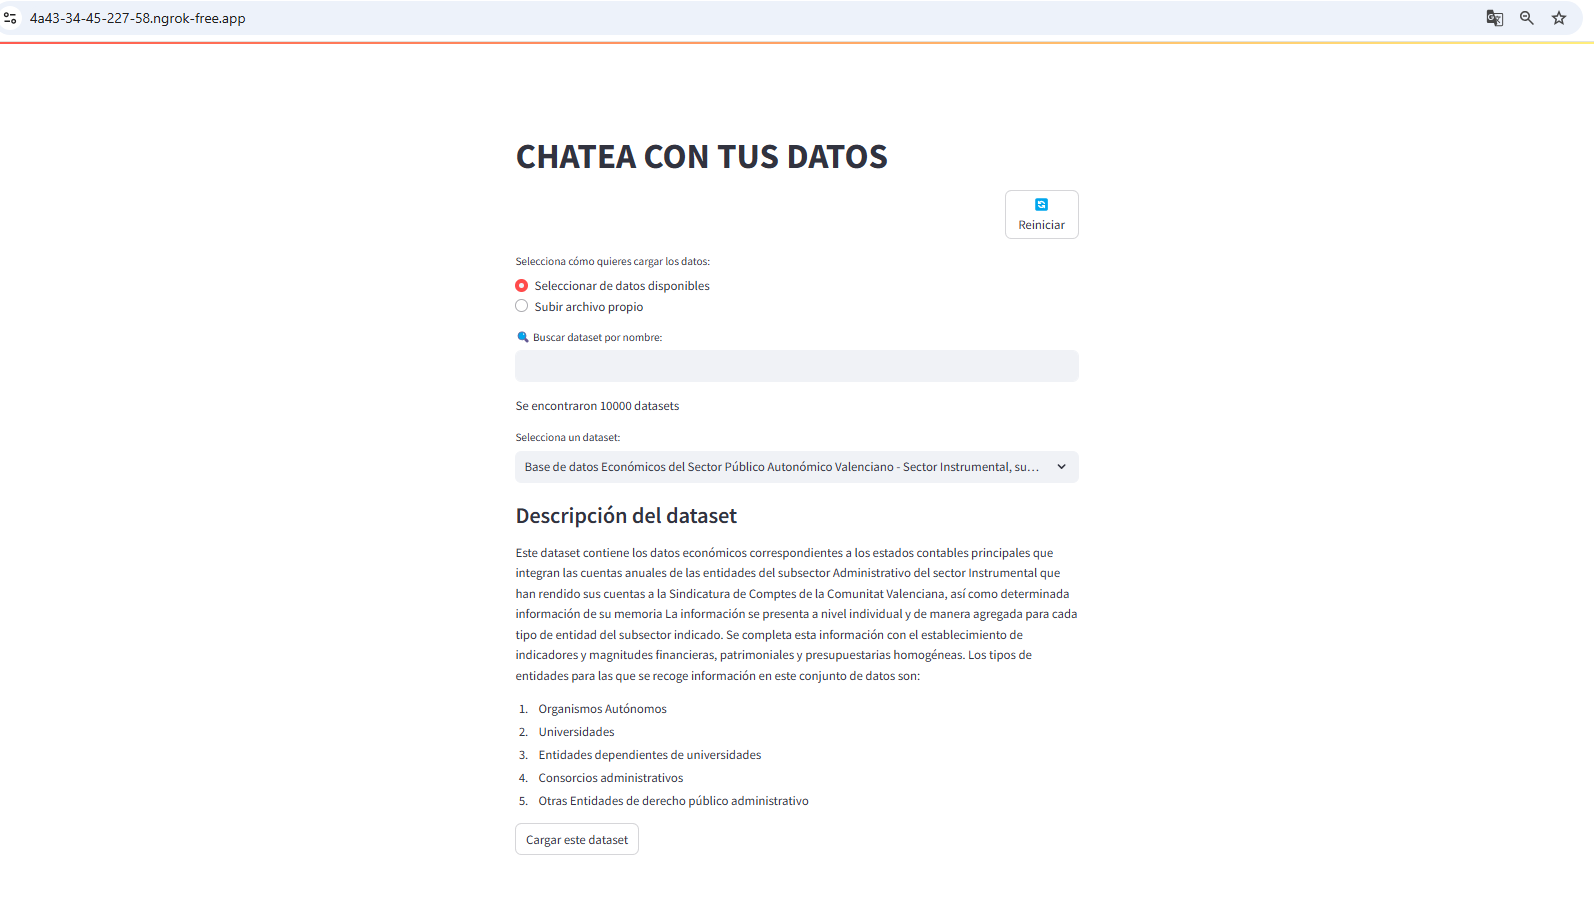

*Figura 2. Imagen principal de la aplicación*

### 6.2 Ejemplo de uso
En la siguiente imagen podemos ver como filtrando por la palabra "vehículos" accedemos a los 18 datasets disponibles que contienen este término. Elegimos cargar "Vehículos municipales 2018" que contiene, como se nos muestra en su descripción, los vehículos municipales del Ayuntamiento de Almendralejo en Junio de 2018.

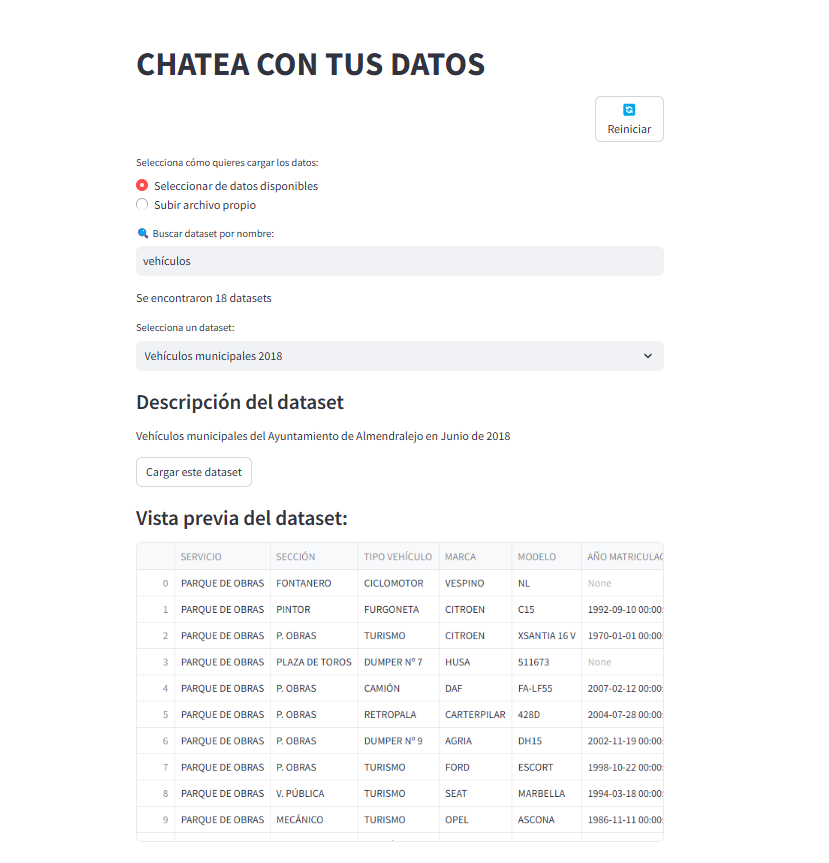

*Figura 3. Selección y carga del dataset*

Una vez se ha cargado el dataset, podemos explorarlo ampliando su tamaño o haciendo busquedas gracias a las funcionalidades reactivas que proporciona el componente "dataframe" de streamlit.

Elegimos consultar al modelo sobre la distribución de los años de matriculación de los vehículos y obtenemos, tras dos intentos, un gráfico que nos permite ver perfectamente una distribución sesgada a la derecha con vehículos mayormente matriculados en el período 2005-2010.Los datos sugieren una política de renovación gradual, manteniendo algunos vehículos más antiguos para funciones específicas.

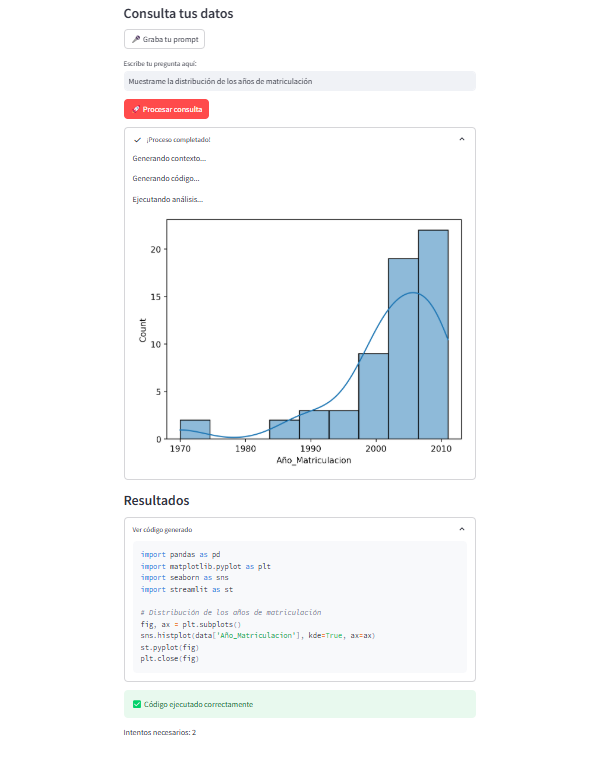

*Figura 4. Análisis de distribución de vehículos*

Adicionalmente, podría ser interesante analizar esta misma distribución agrupada por el tipo de servicio que presta el ayuntamiento, identificando, por ejemplo, servicios que no se han renovado por funciones específicas, como podría ser el parque de obras.

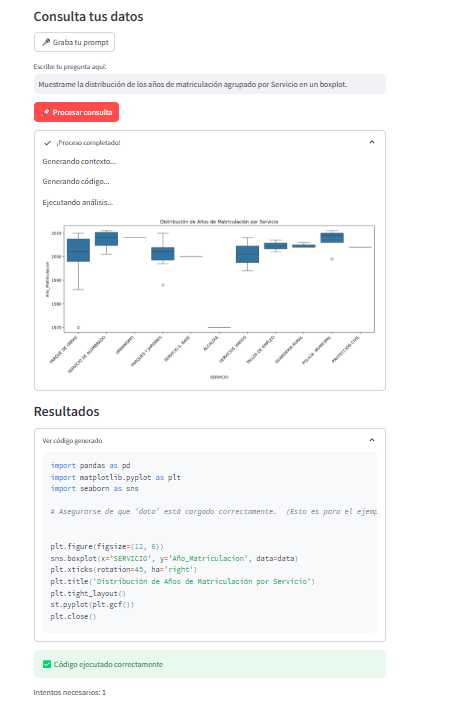

*Figura 5. Análisis de distribución  vehículos-servicios*

Gracias a aplicaciones como esta, el personal técnico y administrativo de los ayuntamientos podría realizar consultas y análisis de datos de forma ágil y sencilla, sin necesidad de conocimientos avanzados en programación o estadística.

Por ejemplo, un responsable del parque móvil municipal podría rápidamente visualizar la antigüedad media de la flota, identificar qué vehículos necesitarán ser renovados próximamente, o analizar la distribución de tipos de vehículos por departamento. Esta información resulta invaluable para la toma de decisiones presupuestarias, la planificación de nuevas adquisiciones y la optimización de recursos municipales.